# 모델 훈련


## 모델1 사용할 특성

1. CryoSleep
2. HomePlanet
3. Age
4. AmenitiesFare_1
5. AmenitiesFare_2
6. Destination
7. deck
8. side

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
os.chdir(os.path.abspath('.'))
!pwd

/home/skang/Documents/kaggle/spaceship_titanic/notebooks


In [4]:
df_train = pd.read_csv('../input/spaceship-titanic/train.csv')
df_test = pd.read_csv('../input/spaceship-titanic/test.csv')

분석을 위해 특성 추가

In [5]:
df_train["PassengerGroup"] = df_train['PassengerId'].apply(lambda x: x.split("_")[0])
df_train = pd.merge(df_train, pd.DataFrame(df_train[["PassengerGroup"]].value_counts(), columns=["GroupSize"]).reset_index(), on="PassengerGroup", how="left")

In [6]:
df_train["AmenitiesFare_1"] = df_train[["RoomService", "ShoppingMall"]].sum(axis=1).apply(lambda x: np.log(x) if x > 0 else 0)
df_train["AmenitiesFare_2"] = df_train[["FoodCourt", "Spa", "VRDeck"]].sum(axis=1).apply(lambda x: np.log(x) if x > 0 else 0)    
df_train["Deck"] = df_train["Cabin"].str.split("/").str[0]
df_train["Side"] = df_train["Cabin"].str.split("/").str[2]

In [7]:
def add_v1_features(df):
    """모델 version 1에 사용할 특징을 추가한다.

    Args:
        df (pd.DataFrame): 사용할 데이터
        
    Returns:
        pd.DataFrame: 사용할 특징을 담은 데이터
    """
    v1_features = ["CryoSleep", "HomePlanet", "Age", "AmenitiesFare_1", "AmenitiesFare_2", "Destination", "Deck", "Side"]
    
    df["AmenitiesFare_1"] = df[["RoomService", "ShoppingMall"]].sum(axis=1).apply(lambda x: np.log(x) if x > 0 else 0)
    df["AmenitiesFare_2"] = df[["FoodCourt", "Spa", "VRDeck"]].sum(axis=1).apply(lambda x: np.log(x) if x > 0 else 0)
    
    df["Deck"] = df["Cabin"].str.split("/").str[0]
    df["Side"] = df["Cabin"].str.split("/").str[2]
    
    return df[v1_features]

In [8]:
def fill_null_features(df):
    pass

In [9]:
def type_check(df):
    pass

In [10]:
print(f"train data_len: {df_train.shape[0]}")
print(f"test data_len: {df_test.shape[0]}")

train data_len: 8693
test data_len: 4277


# Feature engineering

## 이름 대체하기

뒷 부분은 성에 해당하므로 특별히 관련이 없을 것이라 생각,     
이름에 해당하는 앞부분만 사용한다.

In [11]:
df_train['Name'] = df_train.Name.str.extract('([A-Za-x]+) ')
df_test['Name'] = df_test.Name.str.extract('([A-Za-x]+) ')

In [12]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,GroupSize,AmenitiesFare_1,AmenitiesFare_2,Deck,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham,False,0001,1,0.000000,0.000000,B,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna,True,0002,1,4.897840,6.400257,F,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark,False,0003,2,3.761200,9.243775,A,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam,False,0003,2,5.916202,8.477412,A,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,NaN,True,0004,1,6.118097,6.456770,F,S


In [13]:
pd.crosstab(df_train['Name'], df_train['HomePlanet']).T#.style.background_gradient(cmap='summer_r')

Name,Aard,Aarjel,Aark,Aarone,Aars,Acceleb,Achah,Achbah,Achib,Achira,...,rmark,rmino,rmion,rohs,rona,ront,ros,s,sma,ton
HomePlanet,,,,,,,,,,,,,,,,,,,,,
Earth,0,0,0,7,0,0,0,0,0,0,...,0,0,0,0,8,4,0,0,0,3
Europa,0,0,0,0,0,2,2,3,4,4,...,1,2,2,0,0,0,0,0,0,0
Mars,1,2,2,0,1,0,0,0,0,0,...,0,0,0,1,0,0,2,8,3,0


In [14]:
df_train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'PassengerGroup', 'GroupSize', 'AmenitiesFare_1',
       'AmenitiesFare_2', 'Deck', 'Side'],
      dtype='object')

# Null 값 채우기

## CryoSleep

1. CryoSleep == True 승객은 어메니티에 소비를 하지 않는다. 

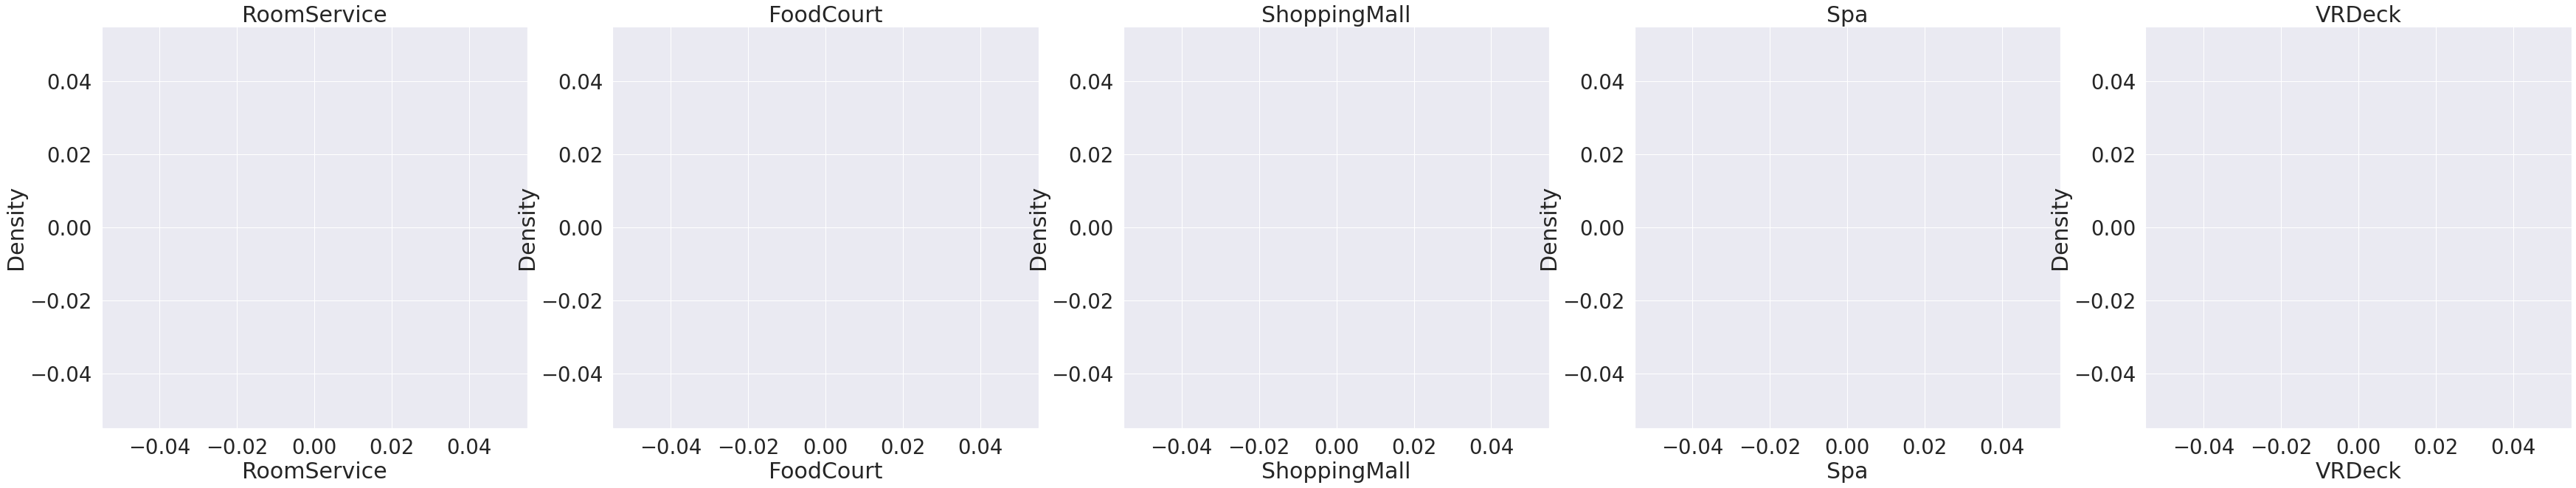

In [15]:
fig, ax = plt.subplots(1, 5, figsize=(60, 10))
for i, amen in enumerate(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']):
    g = sns.kdeplot(df_train[(df_train["CryoSleep"] == True)][amen].map(lambda x: np.log(x) if x > 0 else 0), ax=ax[i])
    g.set_title(amen)


In [16]:
list(df_train["Destination"].unique())[0]

'TRAPPIST-1e'

2. 목적지가 'TRAPPIST-1e'인 승객중 CryoSleep == False인 비율이 많다.

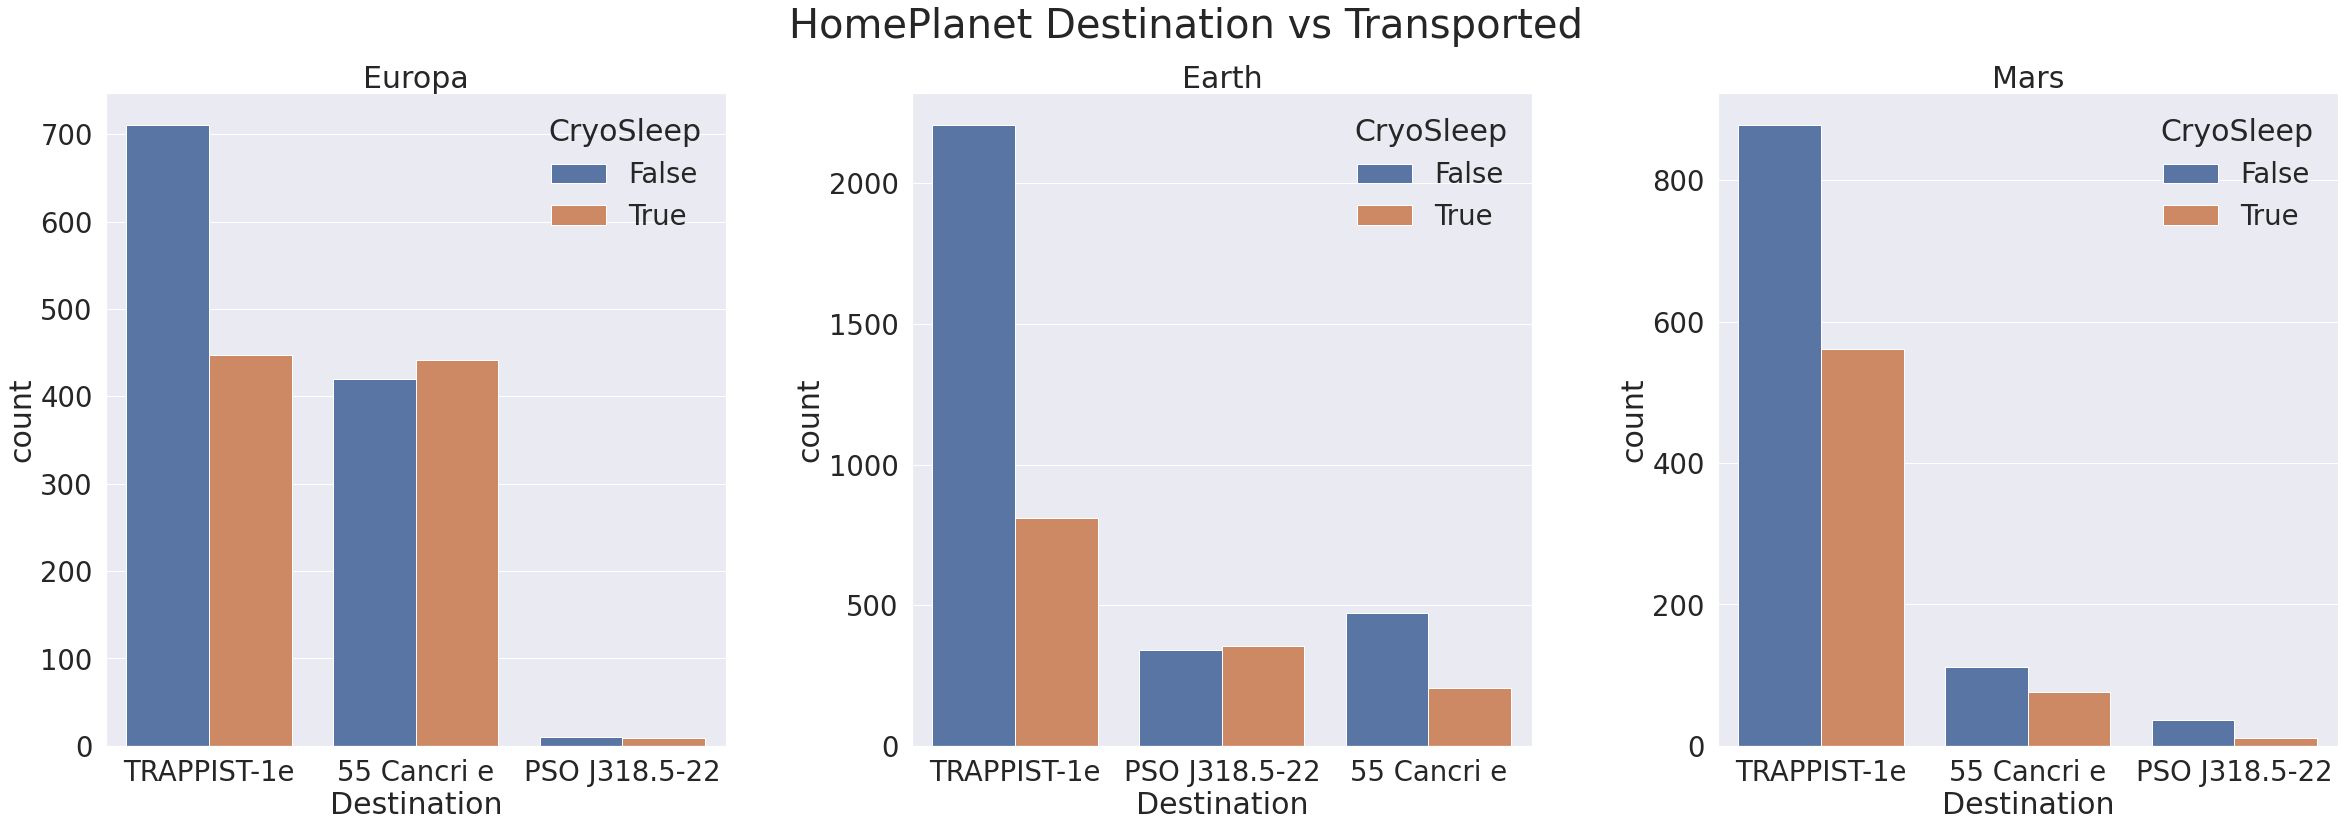

In [17]:
homeplanets = list(df_train["HomePlanet"].unique())[:-1]
destinations = list(df_train["Destination"].unique())[:-1]
f, ax = plt.subplots(1, 3, figsize=(40, 12))
for i, p in enumerate(homeplanets):
    y_position = 1.02
    g = sns.countplot("Destination", hue="CryoSleep", data=df_train[df_train["HomePlanet"]==p], ax=ax[i])
    g.set_title(p)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
f.suptitle("HomePlanet Destination vs Transported", fontsize=40)    
plt.show()

3. GroupSize == 1 또는 HomePlanet == 'Earth'인 승객 중 CryoSleep == False 인 승객의 비율이 높다.

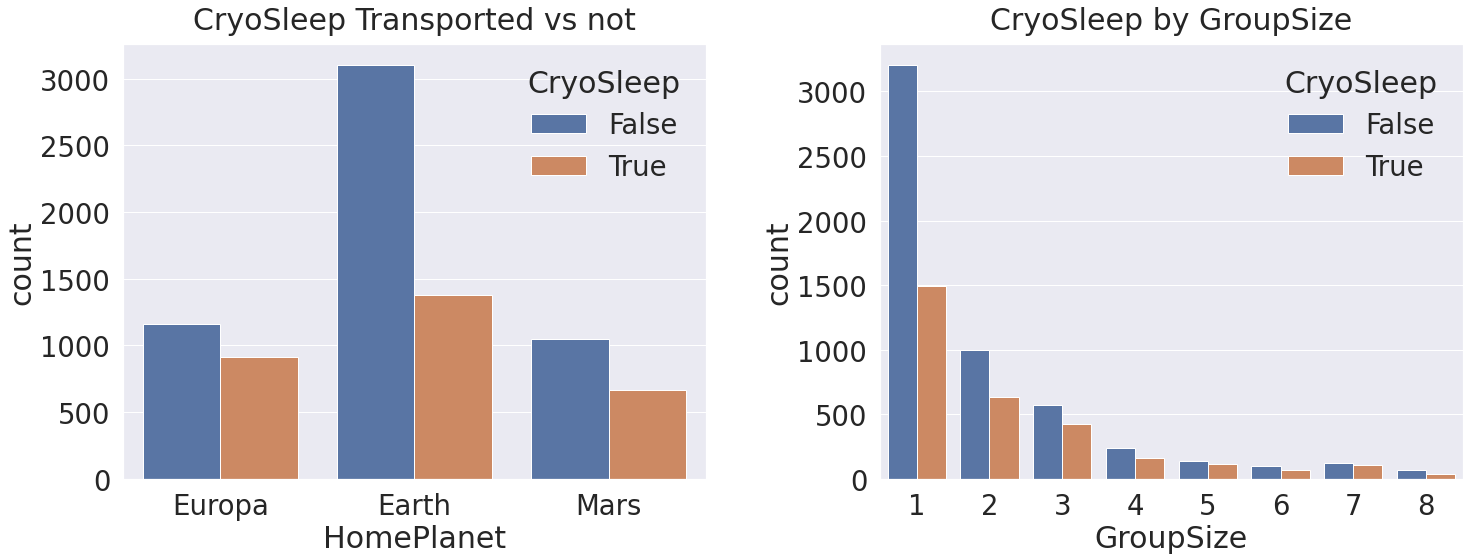

In [18]:
y_position = 1.02
f, ax = plt.subplots(1, 2, figsize=(24, 8))
sns.countplot("HomePlanet", hue="CryoSleep", data=df_train, ax=ax[0])
ax[0].set_title("CryoSleep Transported vs not", y=y_position)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
sns.countplot("GroupSize", hue="CryoSleep", data=df_train, ax=ax[1])
ax[1].set_title("CryoSleep by GroupSize", y=y_position)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [19]:
def fill_cryosleep_null(x):
    
    if pd.isnull(x["CryoSleep"]):
        # 어메니티에 사용한 금액이 없는 경우
        if x[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum() == 0:
            return True
        # 목적지가 "TRAPPIST-1e" 인 경우
        elif x["Destination"] == "TRAPPIST-1e":
            return False
        # 혼자 여행 or 출신지가 Earth인 경우
        elif x["GroupSize"] == 1 or x["HomePlanet"] == "Earth":
            return False
        else:
            return True
    else:
        return x["CryoSleep"]


In [20]:
df_train["CryoSleep"] = df_train.apply(fill_cryosleep_null, axis=1)

## HomePlanet

In [21]:
df_train["HomePlanet"].isnull().sum()

201

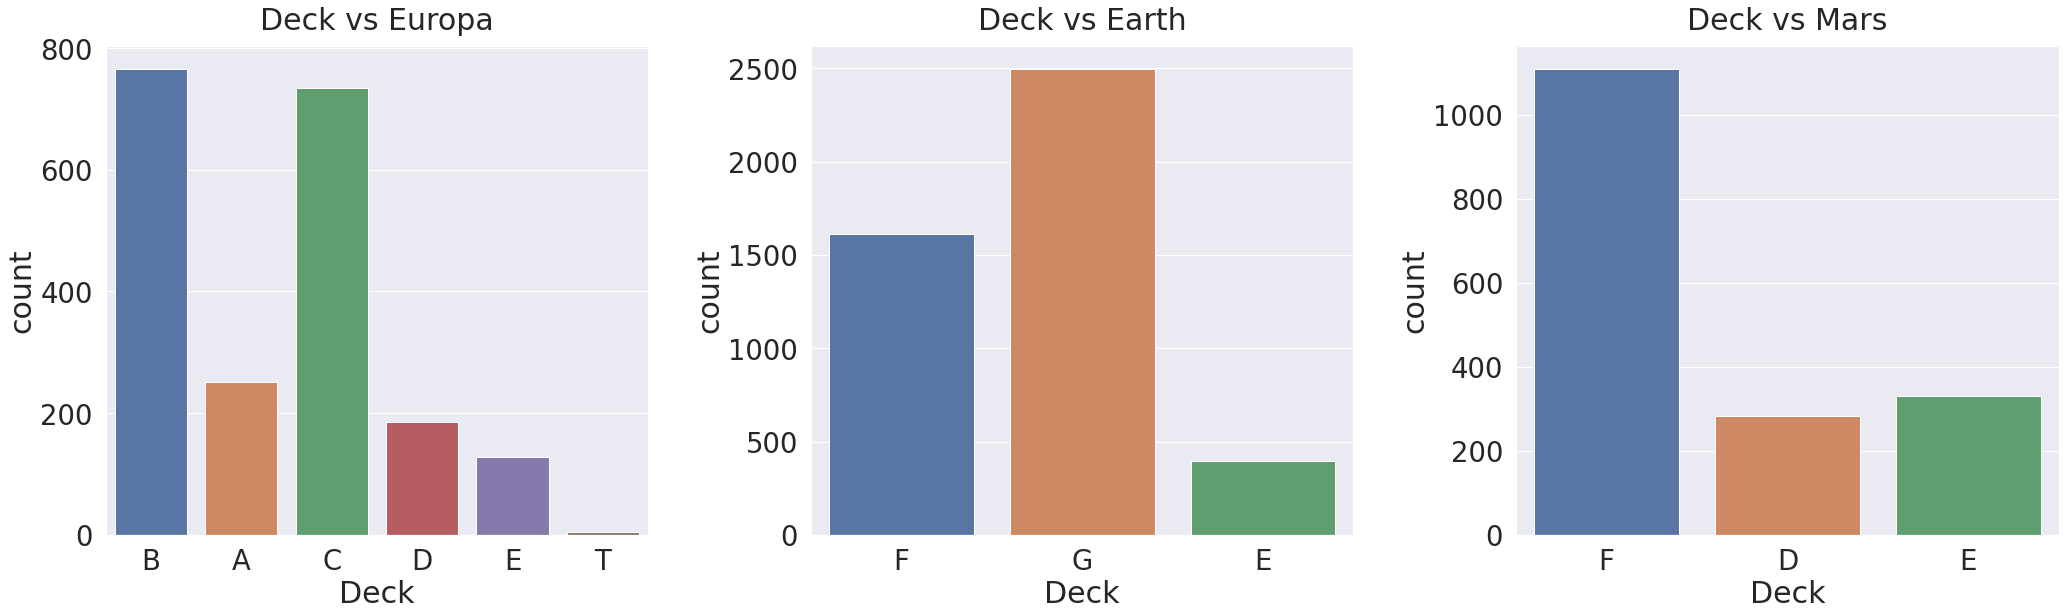

In [22]:
y_position = 1.02
f, ax = plt.subplots(1, 3, figsize=(35, 9))

for i, p in enumerate(list(df_train["HomePlanet"].unique()[:-1])):
    sns.countplot("Deck", data=df_train[df_train["HomePlanet"] == p], ax=ax[i])
    ax[i].set_title(f"Deck vs {p}", y=y_position)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [23]:
count_mars = df_train[(df_train["HomePlanet"] == "Mars")]["Deck"].count()
count_earth = df_train[(df_train["HomePlanet"] == "Earth")]["Deck"].count()
weight =  count_mars / (count_mars + count_earth)

f_earth = df_train[(df_train["Deck"] == 'F') & (df_train["HomePlanet"] == "Earth")]["Deck"].count() / df_train[df_train["Deck"] == 'F']['Deck'].count() * weight
f_mars = df_train[(df_train["Deck"] == 'F') & (df_train["HomePlanet"] == "Mars")]["Deck"].count() / df_train[df_train["Deck"] == 'F']['Deck'].count() * (1 - weight)
print(f"F percentage for Earth : {f_earth}")
print(f"F percentage for Mars : {f_mars}")

F percentage for Earth : 0.15969523023270857
F percentage for Mars : 0.28745231077350464


In [24]:
count_mars = df_train[(df_train["HomePlanet"] == "Mars")]["Deck"].count()
count_europa = df_train[(df_train["HomePlanet"] == "Europa")]["Deck"].count()
weight =  count_mars / (count_mars + count_europa)

d_europa = df_train[(df_train["Deck"] == 'D') & (df_train["HomePlanet"] == "Europa")]["Deck"].count() / df_train[(df_train["Deck"] == "D")]["Deck"].count() * weight
d_mars = df_train[(df_train["Deck"] == 'D') & (df_train["HomePlanet"] == "Mars")]["Deck"].count() / df_train[(df_train["Deck"] == "D")]["Deck"].count() * (1 - weight)
print(f"D percentage for Europa : {d_europa}")
print(f"D percentage for Mars : {d_mars}")

D percentage for Europa : 0.17670541814522536
D percentage for Mars : 0.3220499443885388


vs Deck
1. deck == G => Earth
2. deck == F, D => Mars
3. deck in ["A", "B", "C", "E", "T"] => Europa

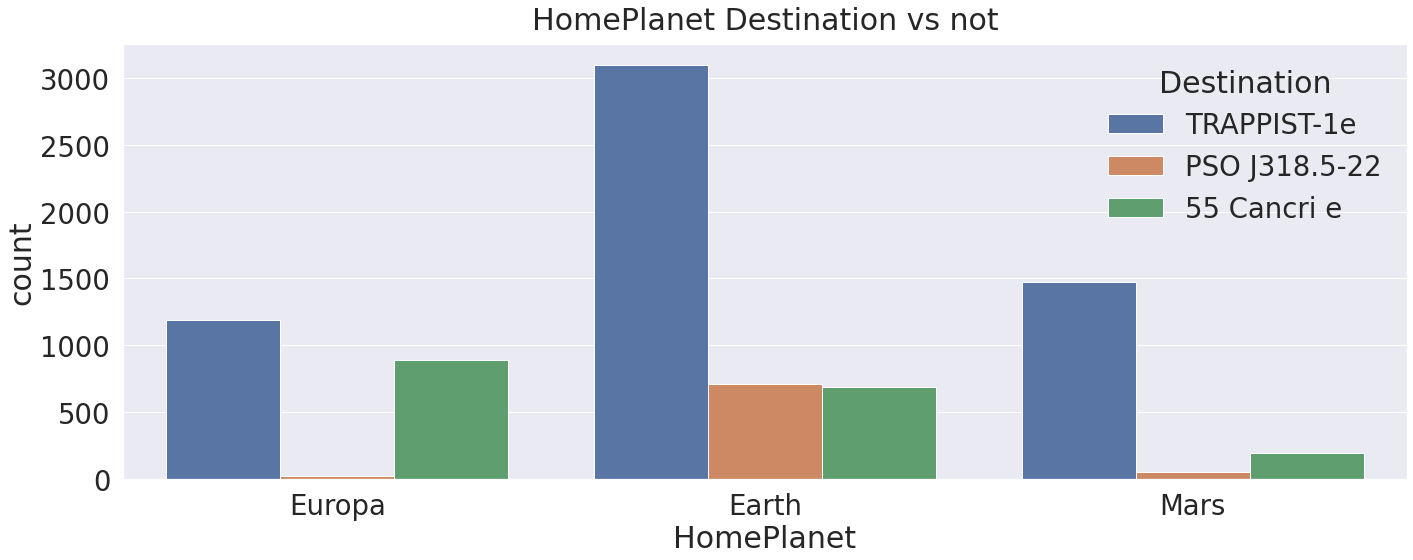

In [25]:
y_position = 1.02
f, ax = plt.subplots(1, 1, figsize=(23, 8))
sns.countplot("HomePlanet", hue="Destination", data=df_train, ax=ax)
ax.set_title("HomePlanet Destination vs not", y=y_position)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [26]:
df_train["Destination"].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

In [27]:
count_earth = df_train[(df_train["HomePlanet"] == "Earth")]["Deck"].count()
count_europa = df_train[(df_train["HomePlanet"] == "Europa")]["Deck"].count()
weight =  count_earth / (count_earth + count_europa)

d_europa = df_train[(df_train["Destination"] == '55 Cancri e') & (df_train["HomePlanet"] == "Europa")]["Destination"].count() / df_train[(df_train["Destination"] == "55 Cancri e")]["Destination"].count() * weight
d_earth = df_train[(df_train["Destination"] == '55 Cancri e') & (df_train["HomePlanet"] == "Mars")]["Destination"].count() / df_train[(df_train["Destination"] == "55 Cancri e")]["Destination"].count() * (1 - weight)
print(f"55 Cancri e percentage for earth : {d_earth}")
print(f"55 Cancri e percentage for Europa : {d_europa}")

55 Cancri e percentage for earth : 0.03374638893112361
55 Cancri e percentage for Europa : 0.3373035663000693


1. destination == '55 Cancri e' => Europa    
2. destination == 'PSO ... => Earth

### fill homeplanet null

1. deck == F, D => Mars
2. deck in ["A", "B", "C", "E", "T"] => Europa
3. destination == '55 Cancri e' => Europa

4. VIP == True => ~ Earth
5. GroupSize == 1 => Earth
6. CryoSleep == False => Earth
7. destination == 'PSO ... => Earth
8. deck == G => Earth

In [28]:
df_train = df_train.copy()

In [29]:
df_train['HomePlanet'].isnull().sum()

201

In [30]:
def fill_homeplanet_null(x):
    if pd.isnull(x["HomePlanet"]):
        # Deck == "F" or "D"
        if x["Deck"] in ['F', 'D']:
            return "Mars"
        # Deck in 
        elif x["Deck"] in ["A", "B", "C", "D", "E", "T"] or x['Destination'] == '55 Cancri e':
            return "Europa"
        else:
            return 'Earth'
    else:
        return x["HomePlanet"]

In [31]:
df_train["HomePlanet"].isnull().sum()

201

In [32]:
df_train["HomePlanet"] = df_train.apply(fill_homeplanet_null, axis=1)
df_train["HomePlanet"].isnull().sum()

0

## Destination

목적지가 PSO인 승객의 대부분은 Earth 출신이다.
대부분의 승객(train 데이터셋의 70%)가 `TRAPPIST-1e` 출신이므로 해당 목적지로 null 값을 채운다.

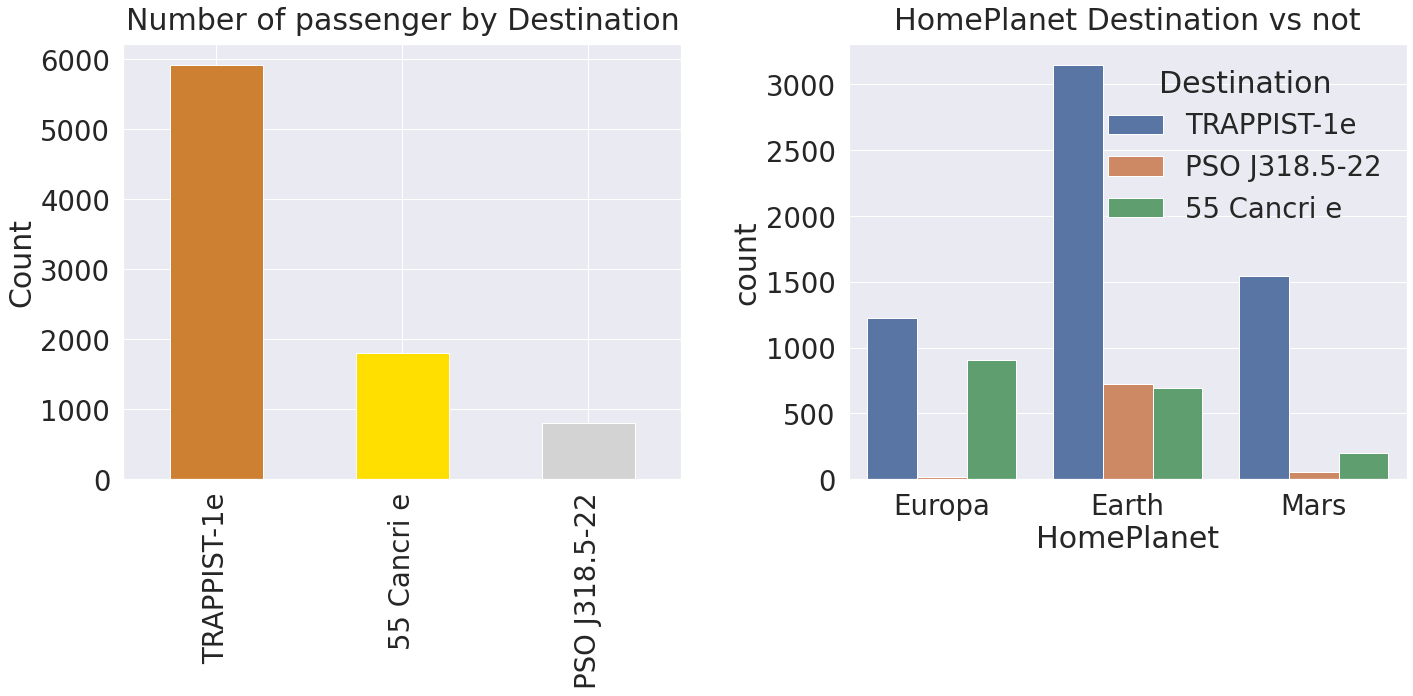

In [33]:
y_position = 1.02
f, ax = plt.subplots(1, 2, figsize=(23, 8))
df_train["Destination"].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'], ax=ax[0])
ax[0].set_title("Number of passenger by Destination", y=y_position)
ax[0].set_ylabel("Count")
sns.countplot("HomePlanet", hue="Destination", data=df_train, ax=ax[1])
ax[1].set_title("HomePlanet Destination vs not", y=y_position)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [34]:
df_train["Destination"].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [35]:
df_train["Destination"].value_counts()[0] / df_train["Destination"].value_counts().sum()

0.6949829632240629

In [36]:
def fill_destination_null(x):
    if pd.isnull(x["Destination"]):
        if x["HomePlanet"] == "Earth":
            return "PSO J318.5-22"
        else:
            return "TRAPPIST-1e"
    else:
        return x["Destination"]

In [37]:
df_train["Destination"].isnull().sum()

182

In [38]:
df_train["Destination"] = df_train.apply(fill_destination_null, axis=1)
df_train["Destination"].isnull().sum()

0

## Age

평균을 기준으로 1 * std 범위내에서 랜덤으로 채우기

In [39]:
age_avg = df_train['Age'].mean()
age_std = df_train['Age'].std()

def fill_age_null(df, age_avg, age_std):
    
    age_null_count = df['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    df['Age'][np.isnan(df['Age'])] = age_null_random_list
    df['Age'] = df['Age'].astype(int)
    
    return df

## AmenitiesFare_1 AmenitiesFare_2

In [40]:
df_train = fill_age_null(df_train, age_avg, age_std)

In [41]:
df_train['Age'].isnull().sum()

0

Age와 마찬가지 방법으로 채우기

In [42]:
df_train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'PassengerGroup', 'GroupSize', 'AmenitiesFare_1',
       'AmenitiesFare_2', 'Deck', 'Side'],
      dtype='object')

In [43]:
AmmenitiesFare_1_avg = df_train['AmenitiesFare_1'].mean()
AmmenitiesFare_1_std = df_train['AmenitiesFare_1'].std()
AmmenitiesFare_2_avg = df_train['AmenitiesFare_2'].mean()
AmmenitiesFare_2_std = df_train['AmenitiesFare_2'].std()

def fill_continuous_null(df, avg, std, col):
    
    null_count = df[col].isnull().sum()
    null_random_list = np.random.randint(avg - std, avg + std, size=null_count)
    df[col][np.isnan(df[col])] = null_random_list
    df[col] = df[col].astype(int)
    
    return df

In [44]:
for c in ["AmenitiesFare_1", "AmenitiesFare_2"]:
    avg = df_train[c].mean()
    std = df_train[c].std()
    df_train = fill_continuous_null(df_train, avg, std, c)

In [45]:
df_train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'PassengerGroup', 'GroupSize', 'AmenitiesFare_1',
       'AmenitiesFare_2', 'Deck', 'Side'],
      dtype='object')

## Deck

행성 별로 deck의 비율을 구한 후 그 값으로 null 값을 채운다.

In [46]:
df_train[["CryoSleep", "HomePlanet", "Age", "AmenitiesFare_1", "AmenitiesFare_2", "Destination", "Deck", "Side"]].isnull().sum()

CryoSleep            0
HomePlanet           0
Age                  0
AmenitiesFare_1      0
AmenitiesFare_2      0
Destination          0
Deck               199
Side               199
dtype: int64

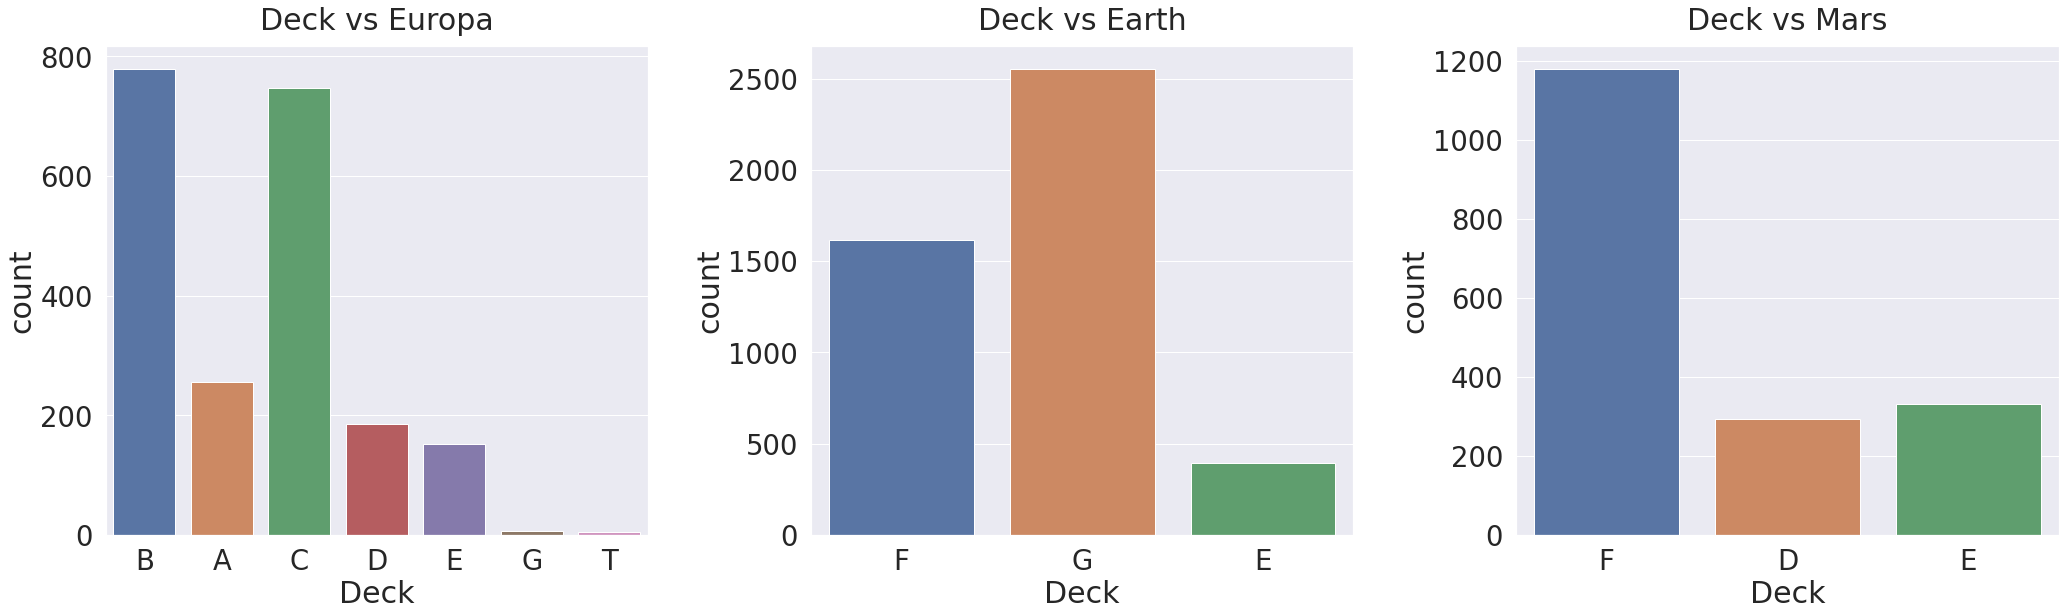

In [47]:
y_position = 1.02
f, ax = plt.subplots(1, 3, figsize=(35, 9))

for i, p in enumerate(list(df_train["HomePlanet"].unique())):
    sns.countplot("Deck", data=df_train[df_train["HomePlanet"] == p], ax=ax[i])
    ax[i].set_title(f"Deck vs {p}", y=y_position)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [48]:
dict_deck = {}

for i, p in enumerate(list(df_train["HomePlanet"].unique())):
    dict_deck[p] = {"deck": list((df_train[(df_train["HomePlanet"] == p)]["Deck"].value_counts() / df_train[(df_train["HomePlanet"] == p)]["Deck"].count()).index), "p": (df_train[(df_train["HomePlanet"] == p)]["Deck"].value_counts() / df_train[(df_train["HomePlanet"] == p)]["Deck"].count()).values}

In [49]:
def fill_deck_null(x, dict_deck):
    if pd.isnull(x["Deck"]):
        planet = x["HomePlanet"]
        if planet == "Europa":
            return np.random.choice(dict_deck[planet]["deck"], 1, p=dict_deck[planet]["p"])[0]
        
        elif planet == "Earth":  
            return np.random.choice(dict_deck[planet]["deck"], 1, p=dict_deck[planet]["p"])[0]
        
        elif planet == "Mars":  
            return np.random.choice(dict_deck[planet]["deck"], 1, p=dict_deck[planet]["p"])[0]
    else:
        return x["Deck"]
            

In [50]:
from functools import partial
fill_deck_null_p = partial(fill_deck_null, dict_deck=dict_deck)
df_train["Deck"] = df_train.apply(fill_deck_null_p, axis=1)

## Side

trainst에서 S와 P 사이의 전체적인 비율이 유사하므로 랜덤하게 샘플링하여 채운다.

In [51]:
def full_side_null(x):
    return np.random.choice(["S", "P"], 1, p=[0.5, 0.5])[0]

In [52]:
df_train.loc[df_train["Side"].isnull(), "Side"] = df_train[df_train["Side"].isnull()]["Side"].apply(lambda x: full_side_null(x))

In [53]:
df_train.Side.isnull().sum()

0

# 카테고리 데이터 인코딩

In [54]:
features_using = ["CryoSleep", "HomePlanet", "Age", "AmenitiesFare_1", "AmenitiesFare_2", "Destination", "Deck", "Side", "Transported"]
df_train = df_train[features_using]

In [55]:
data_cat = df_train[["HomePlanet", "Destination", "Deck", "Side"]]

In [56]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
df_train = pd.concat([df_train.drop(data_cat.columns, axis=1), pd.DataFrame(enc.fit_transform(data_cat).toarray(), columns=list(enc.get_feature_names_out()))], axis=1)

# 모델 훈련

## RF
baseline 모델로 randomforest를 사용하여 훈련한다.

In [57]:
#importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [58]:
df_train

,CryoSleep,Age,AmenitiesFare_1,AmenitiesFare_2,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,False,39,0,0,False,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,False,24,4,6,True,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,False,58,3,9,False,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,False,33,5,8,False,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,False,16,6,6,True,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,41,0,9,False,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8689,True,18,0,0,False,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8690,False,26,7,0,True,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8691,False,32,0,8,False,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [59]:
X_train = df_train.drop('Transported', axis=1).values
target_label = df_train['Transported'].values
X_test = df_test.values

In [60]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2022)

In [61]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [62]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 2608명 중 69.33% 정확도로 생존을 맞춤
